In [1]:
from os import path, listdir
from PIL import Image
import numpy as np

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
def get_data(directory: str) -> "tuple[np.ndarray, np.ndarray]":
    ima = listdir(path.join(directory, "PNEUMONIA"))
    nema = listdir(path.join(directory, "NORMAL"))
    size = len(ima) + len(nema)
    X = np.empty((size, 250, 350), dtype=np.uint8)
    y = np.empty((size), dtype=np.uint8)
    for i, file in enumerate(ima):
        X[i] = np.asarray(Image.open(path.join(directory, "PNEUMONIA", file)))
        y[i] = 1
    for i, file in enumerate(nema):
        X[len(ima) + i] = np.asarray(Image.open(path.join(directory, "NORMAL", file)))
        y[len(ima) + i] = 0
    return X , y

In [4]:
from modeli_stefan import make_model_6

In [5]:
directory_train = "../chest_xray_norm/train"
x_train, y_train = get_data(directory_train)

directory_val = "../chest_xray_norm/val"
x_val, y_val = get_data(directory_val)

In [6]:
model = make_model_6(x_train[0].shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 350)]        0         
_________________________________________________________________
rescaling (Rescaling)        (None, 250, 350)          0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 250, 350)          0         
_________________________________________________________________
tf.clip_by_value (TFOpLambda (None, 250, 350)          0         
_________________________________________________________________
reshape (Reshape)            (None, 250, 350, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 348, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 174, 16)      0     

In [9]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)\

        # Also save the optimizer state
        filepath = self._get_file_path(epoch=epoch, 
            logs=logs)
        filepath = filepath.rsplit( ".", 1 )[ 0 ] 
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
              pickle.dump(
                {
                  'opt': model.optimizer.get_config(),
                  'epoch': epoch+1
                 # Add additional keys if you need to store more values
                }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizaer to %s' % (epoch + 1, filepath))

In [11]:
save_dir = "./checkpoints/stefan/model_6_checkpoints"

In [12]:
checkpoint_cb = MyModelCheckpoint(
path.join(save_dir, 'model-{epoch:03d}-{val_loss:.5f}.hdf5'),
monitor='val_loss',verbose=1)

In [13]:
history = model.fit(x_train, y_train, epochs=70, batch_size=0, verbose=1,
                    shuffle=True, validation_data=(x_val,y_val),callbacks=[checkpoint_cb])

2022-05-27 10:48:29.943267: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-27 10:48:29.963918: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/70


2022-05-27 10:48:31.073045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-27 10:48:31.337391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-27 10:48:32.235027: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-27 10:48:32.288658: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-27 10:48:33.259929: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the av

163/163 [==============================] - 55s 290ms/step - loss: 0.3596 - accuracy: 0.8420 - precision: 0.8660 - recall: 0.9371 - val_loss: 0.5397 - val_accuracy: 0.5625 - val_precision: 0.5455 - val_recall: 0.7500

Epoch 00001: saving model to ./checkpoints/stefan/model_6_checkpoints/model-001-0.53974.hdf5

Epoch 00001: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-001-0.53974.pkl
Epoch 2/70
163/163 [==============================] - 43s 262ms/step - loss: 0.1244 - accuracy: 0.9560 - precision: 0.9717 - recall: 0.9696 - val_loss: 0.1722 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750

Epoch 00002: saving model to ./checkpoints/stefan/model_6_checkpoints/model-002-0.17223.hdf5

Epoch 00002: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-002-0.17223.pkl
Epoch 3/70
163/163 [==============================] - 42s 260ms/step - loss: 0.1039 - accuracy: 0.9622 - precision: 0.9746 - recall: 0.9745 - val_loss: 0.2957 - val_accuracy

163/163 [==============================] - 44s 272ms/step - loss: 0.0362 - accuracy: 0.9882 - precision: 0.9943 - recall: 0.9898 - val_loss: 0.8506 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000

Epoch 00021: saving model to ./checkpoints/stefan/model_6_checkpoints/model-021-0.85063.hdf5

Epoch 00021: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-021-0.85063.pkl
Epoch 22/70
163/163 [==============================] - 35s 214ms/step - loss: 0.0213 - accuracy: 0.9914 - precision: 0.9940 - recall: 0.9944 - val_loss: 0.2116 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000

Epoch 00022: saving model to ./checkpoints/stefan/model_6_checkpoints/model-022-0.21159.hdf5

Epoch 00022: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-022-0.21159.pkl
Epoch 23/70
163/163 [==============================] - 33s 200ms/step - loss: 0.0187 - accuracy: 0.9960 - precision: 0.9975 - recall: 0.9971 - val_loss: 0.6219 - val_accura


Epoch 00040: saving model to ./checkpoints/stefan/model_6_checkpoints/model-040-0.03851.hdf5

Epoch 00040: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-040-0.03851.pkl
Epoch 41/70
163/163 [==============================] - 34s 207ms/step - loss: 0.0072 - accuracy: 0.9981 - precision: 0.9984 - recall: 0.9991 - val_loss: 0.3146 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000

Epoch 00041: saving model to ./checkpoints/stefan/model_6_checkpoints/model-041-0.31457.hdf5

Epoch 00041: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-041-0.31457.pkl
Epoch 42/70
163/163 [==============================] - 32s 199ms/step - loss: 0.0077 - accuracy: 0.9974 - precision: 0.9987 - recall: 0.9978 - val_loss: 0.3128 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000

Epoch 00042: saving model to ./checkpoints/stefan/model_6_checkpoints/model-042-0.31278.hdf5

Epoch 00042: saving optimizaer to ./checkpoints/stefan/model_6_ch

163/163 [==============================] - 33s 205ms/step - loss: 0.0103 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9990 - val_loss: 0.1305 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000

Epoch 00060: saving model to ./checkpoints/stefan/model_6_checkpoints/model-060-0.13054.hdf5

Epoch 00060: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-060-0.13054.pkl
Epoch 61/70
163/163 [==============================] - 33s 204ms/step - loss: 0.0060 - accuracy: 0.9983 - precision: 0.9987 - recall: 0.9990 - val_loss: 0.0211 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000

Epoch 00061: saving model to ./checkpoints/stefan/model_6_checkpoints/model-061-0.02111.hdf5

Epoch 00061: saving optimizaer to ./checkpoints/stefan/model_6_checkpoints/model-061-0.02111.pkl
Epoch 62/70
163/163 [==============================] - 33s 200ms/step - loss: 0.0088 - accuracy: 0.9966 - precision: 0.9980 - recall: 0.9974 - val_loss: 0.1351 - val_accura

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [15]:
import matplotlib.pyplot as plt

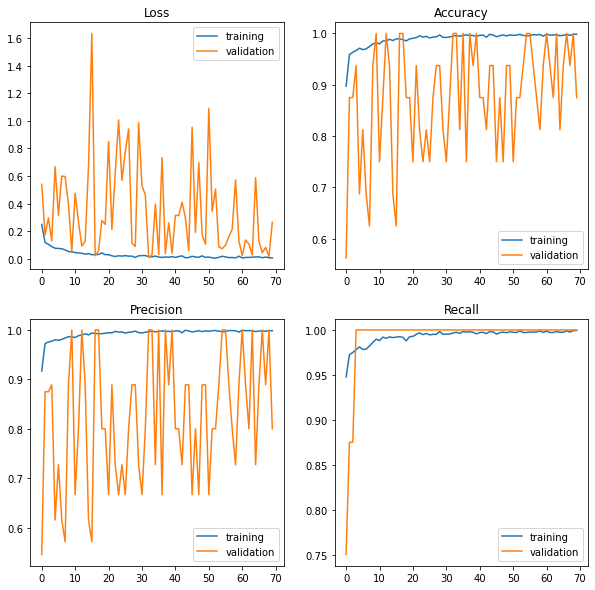

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Loss')
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 2)
plt.title('Accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title('Precision')
plt.plot(history.epoch, history.history['precision'], label='training')
plt.plot(history.epoch, history.history['val_precision'], label='validation')
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title('Recall')
plt.plot(history.epoch, history.history['recall'], label='training')
plt.plot(history.epoch, history.history['val_recall'], label='validation')
plt.legend(loc='best')

plt.show()

In [17]:
model.save("./modeli/stefan/model_6_epoha_70.h5")

In [18]:
import json
  
# Serializing json 
json_history = json.dumps(history.history, indent = 4)
  
# Writing json
with open("./modeli/stefan/model_6_epoha_70.json", "w") as outfile:
    outfile.write(json_history)

In [ ]:
# loadovanje modela
from tensorflow.keras.models import load_model

model2 = load_model('./modeli/stefan/model_5_epoha_70.h5')

In [ ]:
#loadovanje istorije

with open('./modeli/stefan/model_5_epoha_70.json', 'r') as openfile:
    # Reading from json file
    history2 = json.load(openfile)


In [ ]:
len(history2['loss'])

In [ ]:
#history.history.keys()

In [ ]:
#len(history.history['loss'])

In [23]:
directory_test = "../chest_xray_norm/test"
x_test, y_test = get_data(directory_test)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
#y_pred_round = np.round(y_pred)

In [ ]:
y_pred = y_pred>0.5

In [ ]:
y_pred = y_pred.astype(int)

In [ ]:
#y_test

In [ ]:
#y_pred

In [ ]:
y_pred = np.ravel(y_pred)

In [ ]:
tacnost = [y_pred==y_test]

In [ ]:
#tacnost

In [ ]:
tacnost = np.average(tacnost)

In [ ]:
tacnost

In [88]:
best_model_checkpoint_path = "./checkpoints/stefan/model_6_checkpoints/model-069-0.01439.hdf5"

In [89]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

In [90]:
model_best = load_model(best_model_checkpoint_path)

In [91]:
y_pred_best_prob_test = model_best.predict(x_test)
y_pred_best_prob_val = model_best.predict(x_val)

y_pred_best_prob_test = np.ravel(y_pred_best_prob_test)
y_pred_best_prob_val = np.ravel(y_pred_best_prob_val)

In [92]:
np.unique(np.sort(y_pred_best_prob_val))

array([1.6735685e-10, 1.6061451e-06, 8.0629197e-06, 6.0495699e-04,
       3.5205599e-02, 5.2189022e-02, 5.9766956e-02, 7.4877888e-02,
       9.9929547e-01, 9.9998331e-01, 1.0000000e+00], dtype=float32)

In [109]:
y_pred_best_class_test = y_pred_best_prob_test>0.999

In [110]:
y_pred_best_class_test = y_pred_best_class_test.astype(int)

In [111]:
tacnost = [y_pred_best_class_test==y_test]

In [112]:
tacnost = np.average(tacnost)

In [113]:
tacnost

0.8509615384615384

In [53]:
from sklearn.metrics import f1_score

In [55]:
f1_score(y_test, y_pred_best_prob_test)

0.8511576626240354